# Aim of assignment
Predict the sentiment by Tweets

# 1)- Importing key libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [3]:
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

## 2)- Loading & exploring data

In [4]:
Tweet=pd.read_csv("Airline-Sentiment-2-w-AA.csv",encoding='ISO-8859-1')

In [5]:
Tweet.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [6]:
Tweet.shape

(14640, 20)

In [7]:
len(Tweet)

14640

In [8]:
(len(Tweet)-Tweet.count())/len(Tweet)

_unit_id                        0.000000
_golden                         0.000000
_unit_state                     0.000000
_trusted_judgments              0.000000
_last_judgment_at               0.003825
airline_sentiment               0.000000
airline_sentiment:confidence    0.000000
negativereason                  0.373087
negativereason:confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_id                        0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [9]:
del Tweet['tweet_coord']
del Tweet['airline_sentiment_gold']
del Tweet['negativereason_gold']

In [10]:
Tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

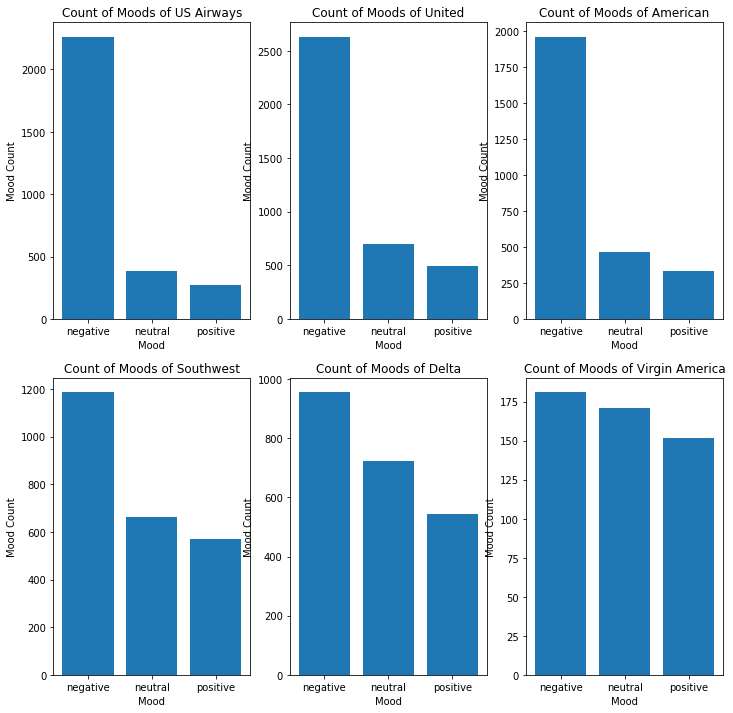

In [11]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots one can find that the distribution of moods for the first three airlines are always skewed toward negative moods. On contrary, the moods are distributed more balanced with the later three airline companies.

###  Reasons of negative sentiments

In [12]:
Tweet['negativereason'][4]

"Can't Tell"

In [13]:
Tweet['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [14]:
NR_Count=dict(Tweet['negativereason'].value_counts(sort=False))

In [15]:
def NR_Count(Airline):
    if Airline=='All':
        df=Tweet
    else:
        df=Tweet[Tweet['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(Tweet['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [16]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

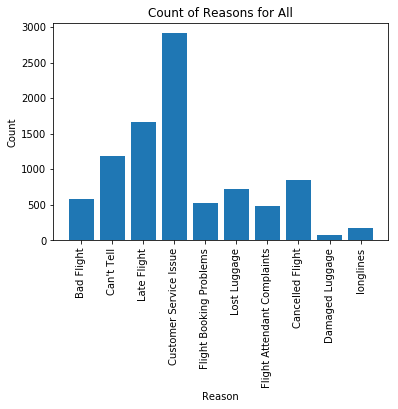

In [17]:
plot_reason('All')

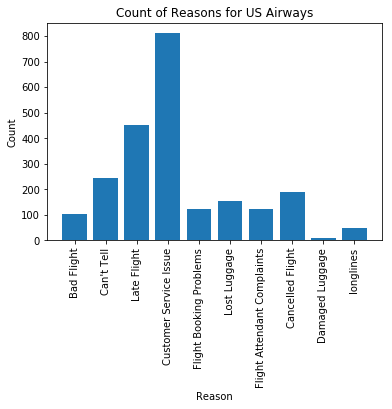

In [18]:
plot_reason('US Airways')

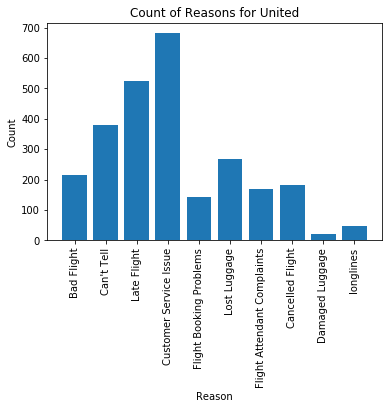

In [19]:
plot_reason('United')

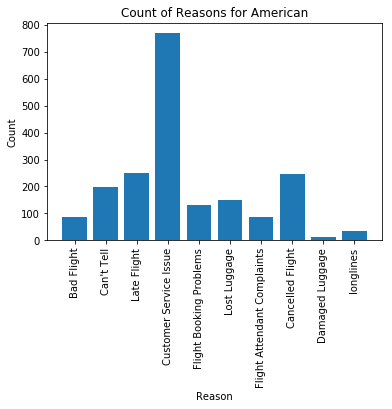

In [20]:
plot_reason('American')

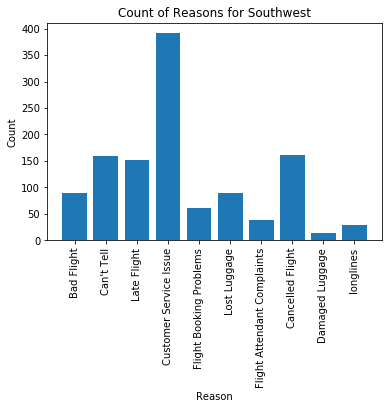

In [21]:
plot_reason('Southwest')

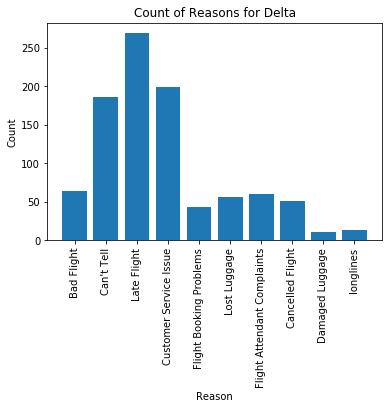

In [22]:
plot_reason('Delta')

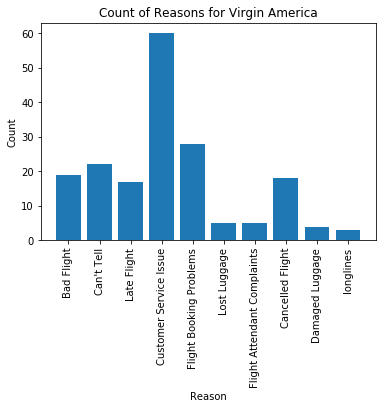

In [23]:
plot_reason('Virgin America')

In [24]:
df=pd.read_csv("Airline-Sentiment-2-w-AA.csv",encoding='ISO-8859-1')

In [25]:
df=df[['airline_sentiment','text']]

In [26]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [27]:
len(df)

14640

In [28]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5,1,'Value Count of Sentiments')

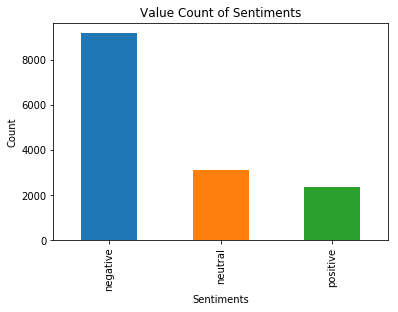

In [29]:
df['airline_sentiment'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.title('Value Count of Sentiments')

In [30]:
from wordcloud import WordCloud,STOPWORDS

In [31]:
df_tweet=df[df['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [32]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

# 3)-Data cleaning and preprocess data

In [33]:
import re
import nltk
from nltk.corpus import stopwords

In [34]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [35]:
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In [36]:
Tweet['sentiment']=Tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

### 3.1)-Splitting dataset

In [37]:
Tweet['clean_tweet']=Tweet['text'].apply(lambda x: tweet_to_words(x))
Tweet['Tweet_length']=Tweet['text'].apply(lambda x: clean_tweet_length(x))
train,test = train_test_split(Tweet,test_size=0.2,random_state=42)

In [38]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

### 3.2)-Vectorization

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

# 4)-Model

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [41]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [42]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))   

Accuracy of LogisticRegressionis 0.6451502732240437
Accuracy of KNeighborsClassifieris 0.5891393442622951
Accuracy of SVCis 0.6451502732240437
Accuracy of DecisionTreeClassifieris 0.762636612021858
Accuracy of RandomForestClassifieris 0.8121584699453552
Accuracy of AdaBoostClassifieris 0.7855191256830601
Accuracy of GaussianNBis 0.5724043715846995


### 4.1)-Model performances

Text(0.5,1,'Accuracies of Models')

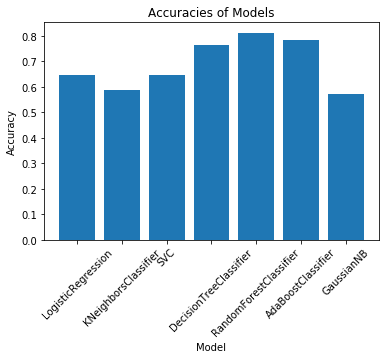

In [43]:
Index = [1,2,3,4,5,6,7]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')